# Importing libraries

In [93]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.sparse import csr_matrix
import pickle
# import cv2 as cv
# import time

# Defining paths

In [2]:
cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_02_IL'
path_table = os.path.join(cur_dir, 'behavior', 'table_cut.csv')
path_mat_spikes = os.path.join(cur_dir, 'spikes', 'finalSpikesMat.mat')

# Parameters

In [81]:
framerate_inscopix = 20
framerate_behavior = 15
frame_count = np.array([4015, 3709, 3872, 3715, 3737, 3752, 4344, 3698, 4628, 3801, 3770, 3774])
discard_sessions = np.array([8,9])
dict_env = {'t_maze': [0, 3, 6],
            'y_maze': [1, 4, 7, 8],
            'open_field': [2, 5, 9]}

# Loading files

## Table frames

In [35]:
df_frames = pd.read_csv(path_table, index_col = 0)
df_frames['session'] = ''
for i,r in df_frames.iterrows():
    df_frames.loc[i, 'session'] = df_frames.loc[i, 'file'].split('.')[0]

## Matrix spikes

### Loading

In [5]:
with h5py.File(path_mat_spikes, 'r') as f:
    mat_spikes = csr_matrix((f['finalSpikesMat']['data'], f['finalSpikesMat']['ir'], f['finalSpikesMat']['jc']))
    mat_spikes = mat_spikes.toarray()

### Plotting first neurons for sanity check

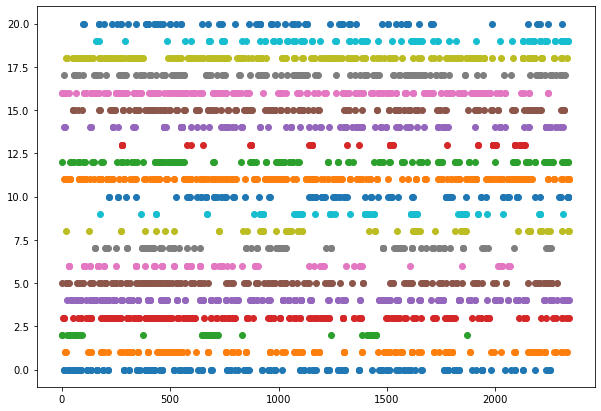

In [6]:
plt.figure(figsize = (10,7))
for (i,r) in enumerate(mat_spikes.T):
    if i > 20:
        break
    spikes = np.where(r)[0]
    plt.scatter(spikes/framerate_inscopix, [i] * len(spikes))

### Getting recording ratios

In [7]:
meta_spikes = pd.DataFrame(index = range(mat_spikes.shape[0]), columns = ['session', 'frame_number', 'frame_ratio'])

cursor = 0
cur_session = -1
for i, fcount in enumerate(frame_count):
    
    end_cursor = cursor + fcount - 1
    if i in discard_sessions:
        session_label = 'discarded' 
    else:
        cur_session += 1
        session_label = df_frames.loc[cur_session, 'file'].split('.')[0]
        
    meta_spikes.loc[cursor:end_cursor, 'session'] = session_label
    meta_spikes.loc[cursor:end_cursor, 'frame_number'] = range(fcount)
    meta_spikes.loc[cursor:end_cursor, 'recording_ratio'] = meta_spikes.loc[cursor:end_cursor, 'frame_number'] / (fcount - 1)
    cursor += fcount

from collections import Counter
print(Counter(meta_spikes['session']))
meta_spikes

Counter({'discarded': 8429, 'WIN_20211204_16_41_36_Pro': 4344, 'WIN_20211204_16_16_59_Pro': 4015, 'WIN_20211204_16_25_36_Pro': 3872, 'WIN_20211204_17_04_46_Pro': 3774, 'WIN_20211204_16_58_42_Pro': 3770, 'WIN_20211204_16_37_29_Pro': 3752, 'WIN_20211204_16_33_22_Pro': 3737, 'WIN_20211204_16_29_32_Pro': 3715, 'WIN_20211204_16_21_25_Pro': 3709, 'WIN_20211204_16_46_16_Pro': 3698})


,session,frame_number,frame_ratio,recording_ratio
0,WIN_20211204_16_16_59_Pro,0,NaN,0.0
1,WIN_20211204_16_16_59_Pro,1,NaN,0.000249
2,WIN_20211204_16_16_59_Pro,2,NaN,0.000498
3,WIN_20211204_16_16_59_Pro,3,NaN,0.000747
4,WIN_20211204_16_16_59_Pro,4,NaN,0.000997
...,...,...,...,...
46810,WIN_20211204_17_04_46_Pro,3769,NaN,0.99894
46811,WIN_20211204_17_04_46_Pro,3770,NaN,0.999205
46812,WIN_20211204_17_04_46_Pro,3771,NaN,0.99947
46813,WIN_20211204_17_04_46_Pro,3772,NaN,0.999735


## Deep lab cut

### Loading

In [8]:
dlc_files = np.array(os.listdir(os.path.join(cur_dir, 'dlc')))
dlc_files = dlc_files[[s.endswith('filtered.csv') for s in dlc_files]]
if len(dlc_files) != 1:
    sys.exit('There should be only one DLC file, this is not the case')
dlc_files = dlc_files[0]
df_dlc = pd.read_csv(os.path.join(cur_dir, 'dlc', dlc_files), skiprows = 2, index_col = 0)
df_dlc['xc'] = 0
df_dlc['yc'] = 0
for i,r in df_dlc.iterrows():
    df_dlc.loc[i, 'xc'] = np.mean([r['x'], r['x.1'], r['x.2'], r['x.3']])
    df_dlc.loc[i, 'yc'] = np.mean([r['y'], r['y.1'], r['y.2'], r['y.3']])
df_dlc

,x,y,likelihood,x.1,y.1,likelihood.1,x.2,y.2,likelihood.2,x.3,y.3,likelihood.3,xc,yc
coords,,,,,,,,,,,,,,
0,530.613342,78.823959,0.999390,523.279419,89.661072,0.997744,532.317932,90.384064,0.999183,526.642700,99.858376,0.996780,528.213348,89.681868
1,530.613342,78.903107,0.999396,523.362610,89.775871,0.998029,532.394836,90.384064,0.999172,526.753052,99.858376,0.997734,528.280960,89.730354
2,530.613342,78.903107,0.999281,523.369080,89.775871,0.998121,532.621399,90.384064,0.999274,527.148193,99.858376,0.997790,528.438004,89.730354
3,530.628174,78.903107,0.999192,523.362610,89.661072,0.997507,532.666260,90.420189,0.999157,526.753052,99.705284,0.996848,528.352524,89.672413
4,530.628174,78.392883,0.999483,523.279419,88.976715,0.997271,532.668884,90.420189,0.999363,526.753052,99.657654,0.997779,528.332382,89.361860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28808,361.354065,218.538712,0.992324,356.758820,230.289749,0.953380,366.374908,225.682312,0.256368,371.941345,228.365768,0.174458,364.107285,225.719135
28809,368.778595,220.275467,0.697572,357.282135,230.554153,0.814738,366.374908,224.552597,0.052562,373.792755,225.677414,0.063438,366.557098,225.264908
28810,374.742920,222.518860,0.180616,357.324799,230.554153,0.337882,369.226532,226.487366,0.017791,371.941345,225.677414,0.002400,368.308899,226.309448


### Getting recoridng and ts

In [9]:
df_dlc['session'] = ''
df_dlc['frame_number'] = 0
df_dlc['recording_ratio'] = 0
cursor = 0
for i,r in df_frames.iterrows():
    end_cursor = cursor+r['end_frame']-r['start_frame'] 
    df_dlc.loc[cursor:end_cursor, 'session'] = r['file'].split('.')[0]
    df_dlc.loc[cursor:end_cursor, 'frame_number'] = range(r['end_frame'] - r['start_frame'] + 1)
    df_dlc.loc[cursor:end_cursor, 'recording_ratio'] = df_dlc.loc[cursor:end_cursor, 'frame_number'] / (r['end_frame'] - r['start_frame'])
    cursor += (r['end_frame'] - r['start_frame'] + 1)

### Matching spikes to behavioral frames

In [10]:
meta_spikes['behavioral_frame'] = 0
meta_spikes['x'] = 0
meta_spikes['y'] = 0

for i,r in meta_spikes.iterrows():
    cur_session = r['session']
    if r['session'] == 'discarded':
        continue
    sub_df_dlc = df_dlc.query('session == @cur_session')    
    meta_spikes.loc[i,'behavioral_frame'] = sub_df_dlc.index[np.argmin(np.abs(r['recording_ratio'] - sub_df_dlc['recording_ratio']))]
    meta_spikes.loc[i,'x'] = df_dlc.loc[meta_spikes.loc[i, 'behavioral_frame']]['xc']
    meta_spikes.loc[i,'y'] = df_dlc.loc[meta_spikes.loc[i, 'behavioral_frame']]['yc']
    if i%1000 == 0:
        print('%05d/%d' % (i, meta_spikes.shape[0]))

01000/46815


In [11]:
meta_spikes

,session,frame_number,frame_ratio,recording_ratio,behavioral_frame,x,y
0,WIN_20211204_16_16_59_Pro,0,NaN,0.0,0,528.213348,89.681868
1,WIN_20211204_16_16_59_Pro,1,NaN,0.000249,1,528.280960,89.730354
2,WIN_20211204_16_16_59_Pro,2,NaN,0.000498,2,528.438004,89.730354
3,WIN_20211204_16_16_59_Pro,3,NaN,0.000747,2,528.438004,89.730354
4,WIN_20211204_16_16_59_Pro,4,NaN,0.000997,3,528.352524,89.672413
...,...,...,...,...,...,...,...
46810,WIN_20211204_17_04_46_Pro,3769,NaN,0.99894,28809,366.557098,225.264908
46811,WIN_20211204_17_04_46_Pro,3770,NaN,0.999205,28810,368.308899,226.309448
46812,WIN_20211204_17_04_46_Pro,3771,NaN,0.99947,28810,368.308899,226.309448
46813,WIN_20211204_17_04_46_Pro,3772,NaN,0.999735,28811,365.364342,226.309448


### Checking offset between recordings

In [12]:
duration_inscopix = (np.sum(frame_count) - np.sum([frame_count[idx] for idx in discard_sessions])) / framerate_inscopix
duration_behavior = df_dlc.shape[0] / framerate_behavior
time_diff = np.abs(duration_inscopix - duration_behavior)
avg_shit_session = time_diff / len(pd.unique(df_dlc['session']))
print('Duration behavior: %.2fs\nDuration inscopix: %.2fs\nTime difference: %.2fs\nAverage shift per session: %.2fs' % (duration_behavior, duration_inscopix, time_diff, avg_shit_session))

Duration behavior: 1920.87s
Duration inscopix: 1919.30s
Time difference: 1.57s
Average shift per session: 0.16s


# Saving

In [97]:
os.makedirs(os.path.join(cur_dir, 'pickle'), exist_ok=False)
with open(os.path.join(cur_dir, 'pickle', 'meta_spikes.pck'), 'wb') as f:
    pickle.dump(meta_spikes, f)
with open(os.path.join(cur_dir, 'pickle', 'df_dlc.pck'), 'wb') as f:
    pickle.dump(df_dlc, f)
with open(os.path.join(cur_dir, 'pickle', 'df_frames.pck'), 'wb') as f:
    pickle.dump(df_frames, f)    
with open(os.path.join(cur_dir, 'pickle', 'mat_spikes.pck'), 'wb') as f:
    pickle.dump(mat_spikes, f)  